# <center> Newman on custom trace and user graph </center>

In [2]:
import sys
import util
import numpy as np
import networkx as nx
import random as random
from time import time
from operator import itemgetter
import matplotlib.pyplot as plt
from math import log

Trace and real graph path.

In [3]:
trace_path = "../Newman/rapportStage/trace_power.txt"
graph_path = "../Newman/rapportStage/adjList_power.txt"

Out path.

In [4]:
out_path = "../Newman/rapportStage/results_power/"

Get authors.

In [5]:
Author = util.get_authors(trace_path)

Get users.

In [6]:
users = set(Author.values())
# print(users)

In [7]:
for i,line in enumerate(open(trace_path)):
    print(line[:-1]) # [:-1] to remove \n at end of line
    if i==5:
        break

1 0.002484055072516158 85 -1
2 0.006617376663445858 56 -1
3 0.008911607768234504 98 -1
4 0.010856463123318161 99 -1
5 0.0137722536461546 10 -1
6 0.01427960755043431 56 -1


Useful function to flatten a list of lists or values from dict of dicts.

In [8]:
def flatten(obj):
    if type(obj) == list:
        return [l for L in obj for l in L]
    if type(obj) == dict:
        return [l for i in obj for l in obj[i].values()]

# example
liste = [[3,5], [0,-7,12], [45]]
print("Example on {} : {}".format(liste, flatten(liste)))
dico = {1: {4:56, 2:45}, 3: {6:32}}
print("Example on {} : {}".format(dico, flatten(dico)))

Example on [[3, 5], [0, -7, 12], [45]] : [3, 5, 0, -7, 12, 45]
Example on {1: {4: 56, 2: 45}, 3: {6: 32}} : [56, 45, 32]


## 1. Initialization

Number of nodes $n$ and list of all node pairs.

In [9]:
n = len(users)
node_pairs = list()
for i in range(n):
    for j in range(n):
        if i != j:
            node_pairs.append((i,j))

Compute E and N.

In [10]:
maxE = 100

In [12]:
# init
E = dict()

# read tweets
for i,line in enumerate(open(trace_path)):
    line = line.split()
    uid, rtid = int(line[2]), int(line[3])
    
    # if retweet of known author
    if rtid != -1 and rtid in Author:
        rtu = Author[rtid]
        if rtu != uid: # no self-edges
            if uid in E:
                if rtu in E[uid] and E[uid][rtu] < maxE:
                    E[uid][rtu] += 1
                else:
                    E[uid][rtu] = 1
            else:
                E[uid] = {rtu: 1}

N = {u: max(flatten(E)) for u in users}
print("N = ", set(N.values()))

N =  {91}


## 2. Iterations

Choose parameters.

In [13]:
eps = 0.001
repetitions = 100
max_iter = 100
verbose = False

Proceed NEW VERSION SPARSE.

In [14]:
# at each repetition we save the values of w, a and b
results = {'w':list(), 'a':list(), 'b':list()}

start = time()
for k in range(repetitions):
    
    # we may have divisions by zero
    try:
    
        # random initialization of the parameters
        w = random.uniform(0, 0.2)
        a = random.uniform(0.5, 1)
        b = random.uniform(0, 0.5)
#         w = random.random()
#         a = random.random()
#         b = random.random()
        if verbose:
            print("init values ", w, a, b)
            print()

        # iter
        for l in range(max_iter):
            
            # print state
            sys.stdout.flush()
#             sys.stdout.write("repetition {}/{} --- iteration {}/{} --- elapsed time {:.3f}\r"
#                              .format(k+1, repetitions, l+1, max_iter, time()-start))
            sys.stdout.write("repetition {}/{} --- elapsed time {:.3f}\r"
                             .format(k+1, repetitions, time()-start))

            old_w, old_a, old_b = w, a, b

            # compute Qij
            Q = dict()
            for i in E:
                ni = N[i]
                Q[i] = dict()
                for j in E[i]:
                    eij = E[i][j]
                    qij = w * a**eij * (1-a)**(ni-eij)
                    qij /= w * a**eij * (1-a)**(ni-eij) + (1-w) * b**eij * (1-b)**(ni-eij)
                    Q[i][j] = qij
            
            # update w,a,b
            w = sum(flatten(Q)) / (n*(n-1))
            numerator_a, numerator_b = 0, 0
            denominator_a, denominator_b = 0, 0
            for i in E:
                ni = N[i]
                for j in E[i]:
                    eij = E[i][j]
                    qij = Q[i][j]
                    numerator_a += qij * eij
                    numerator_b += (1-qij) * eij
                    denominator_a += qij * ni
                    denominator_b += (1-qij) * ni
            a = numerator_a / denominator_a
            b = numerator_b / denominator_b
            if verbose:
                print(w,a,b)
                print()
            
            # break if no sufficient evolution after at least one iteration
            # INCOMPLETE
            new_q = np.array(flatten(Q))
            if l>0 and np.linalg.norm(new_q - old_q) < eps:
                if verbose:
                    print(np.abs([a-old_a, b-old_b, w-old_w]))
                break
            
            # register old_q
            old_q = new_q
            
        # add results to results dict
        results['w'].append(w)
        results['a'].append(a)
        results['b'].append(b)
        
    except e:
        print(e)
        continue

Print results.

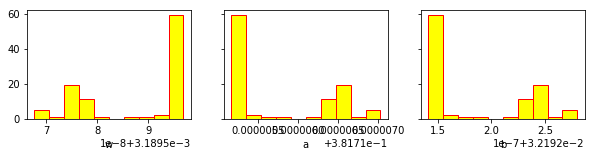

top 5 values for w and proportion
0.003 1.0

top 5 values for a and proportion
0.382 1.0

top 5 values for b and proportion
0.032 1.0

top 5 values for (w,a,b) and proportion
(0.003, 0.382, 0.032) 1.0



In [15]:
# plot the results
plt.rcParams["figure.figsize"] = [10,2]
fig, ax = plt.subplots(1, 3, sharey=True)
for i,(key,values) in enumerate(results.items()):
    values = sorted(values)
    ax[i].hist(values, label=key, facecolor='yellow', edgecolor='red')
    ax[i].set_xlabel(key)  
plt.show()
plt.close()

# print results
for key,val in results.items():
    print("top 5 values for {} and proportion".format(key))
    val = [round(v,3) for v in val]
    valcount = list()
    for v in set(val):
        valcount.append((v, val.count(v)/len(val)))
    valcount = sorted(valcount, key=itemgetter(1), reverse=True)
    for x in valcount[:5]:
        print(x[0], x[1])
    print()
    
print("top 5 values for (w,a,b) and proportion")
val = list()
for i in range(len(results['w'])):
    val.append((round(results['w'][i],3), round(results['a'][i],3), round(results['b'][i],3)))
valcount = list()
for v in set(val):
    valcount.append((v, val.count(v)/len(val)))
valcount = sorted(valcount, key=itemgetter(1), reverse=True)
for x in valcount[:5]:
    print(x[0], x[1])
print()

Set w,a,b to the most observed values and compute Q accordingly.

w, a, b =  0.003 0.382 0.032


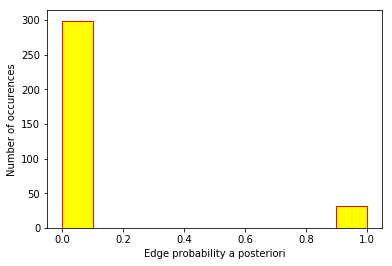

In [16]:
w, a, b = max([(v, val.count(v)/len(val)) for v in set(val)], key=itemgetter(1))[0]

# compute Q
Q = dict()
for i in E:
    ni = N[i]
    Q[i] = dict()
    for j in E[i]:
        eij = E[i][j]
        qij = w * a**eij * (1-a)**(ni-eij)
        qij /= w * a**eij * (1-a)**(ni-eij) + (1-w) * b**eij * (1-b)**(ni-eij)
        Q[i][j] = qij
        
# plot
print("w, a, b = ", w,a,b)
plt.rcParams["figure.figsize"] = [6,4]
plt.hist(flatten(Q), facecolor='yellow', edgecolor='red')
plt.xlabel("Edge probability a posteriori")
plt.ylabel("Number of occurences")
plt.savefig(out_path + "Q_distrib.pdf")
plt.show()
plt.close()

## 3. Result analysis

### 3.1 Plots

Plot E/N vs Q.

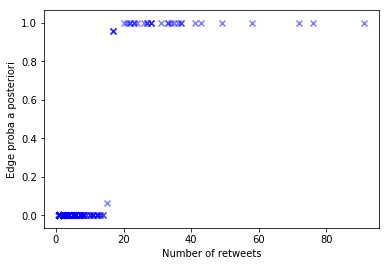

In [17]:
plt.rcParams["figure.figsize"] = [6,4]
x2plot = flatten(E)
y2plot = flatten(Q)
plt.scatter(x2plot, y2plot, color='blue', marker='x', alpha=.5)
plt.xlabel("Number of retweets")
plt.ylabel("Edge proba a posteriori")
plt.savefig(out_path + "EvsQ.pdf")
plt.show()

Get real graph.

In [18]:
G = nx.read_edgelist(graph_path, nodetype=int, create_using=nx.DiGraph())

Plot real graph ?

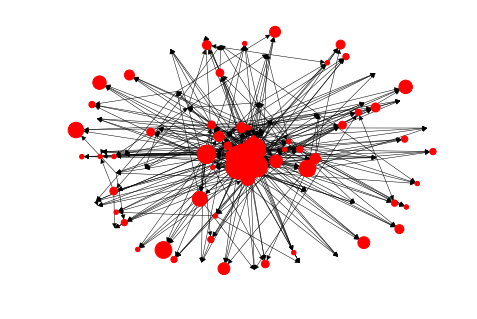

In [73]:
# nx.draw_kamada_kawai(G, node_size=[G.degree[x]**2.3 for x in G.nodes], arrowstyle='->',width=.5,  with_labels=False)
# plt.savefig("simu_userGraph.pdf")
nx.draw(G, node_size=[20*G.out_degree(k) for k in range(n)], width=.5)
plt.savefig(out_path + "graph_random.pdf")

Compare expected degrees.

In [19]:
expected_deg = 2*sum(flatten(Q)) / n
var = 4*sum([q*(1-q) for q in flatten(Q)]) / n**2
std = np.sqrt(var)
print("Expected degree observed : {:.3f} with variance {:.10f} and std_dev {:.3f}".format(expected_deg, var, std))
print("Expected degree estimated from real graph : {:.3f}".format(np.mean([G.degree[n] for n in G.nodes])))

Expected degree observed : 0.625 with variance 0.0000754260 and std_dev 0.009
Expected degree estimated from real graph : 5.760


Compare estimates a,b with real values alpha,beta.

In [20]:
alpha, beta= list(), list()
for e in node_pairs:
    if e in G.edges:
        try:
            alpha.append(E[e[1]][e[0]]/30)
        except:
            alpha.append(0)
    else:
        try:
            beta.append(E[e[1]][e[0]]/30)
        except:
            beta.append(0)
alpha, beta = np.mean(alpha), np.mean(beta)
print("a = {}, alpha = {}".format(a, alpha))
print("b = {}, beta = {}".format(b, beta))

a = 0.382, alpha = 0.12346109175377469
b = 0.032, beta = 0.0031439192777482743


## 4. Compare real graph, oursin, cascade and Newman

Get oursin and cascade graph.

In [21]:
G_oursin = util.nxgraph_from_trace(trace_path, False, Author)
G_cascade = util.nxgraph_from_trace(trace_path, True, Author)

Compare nb edges among all graphs.

In [22]:
print("Mean nb edges in Newman graph : ", 0.5*expected_deg*n)
print("Nb edges in oursin graph : ", G_oursin.number_of_edges())
print("Nb edges in cascade graph : ", G_cascade.number_of_edges())
print("Real nb edges : ", G.number_of_edges())

Mean nb edges in Newman graph :  30.945253898012517
Nb edges in oursin graph :  333
Nb edges in cascade graph :  485
Real nb edges :  288


Compare proportion of common edges.

In [23]:
n_samples = 1000
sample_in_real = list()
real_in_sample = list()
sample_in_oursin = list()
oursin_in_sample = list()
sample_in_cascade = list()
cascade_in_sample = list()

# edges lists
oursin_edges = set(G_oursin.edges)
cascade_edges = set(G_cascade.edges)
real_edges = set(G.edges)

for k in range(n_samples):
    
    # sample graph
    G_sample = nx.DiGraph()
    G_sample.add_nodes_from(users)
    for (i,j) in node_pairs:
        if i in Q:
            if j in Q[i] and random.random() < Q[i][j]:
                G_sample.add_edge(j,i)
    sample_edges = set(G_sample.edges)
            
    # compare edges in sample with real graph
    nb_common_edges = len(sample_edges.intersection(real_edges))
    sample_in_real = nb_common_edges / len(sample_edges)
    real_in_sample = nb_common_edges / len(real_edges)
    
    # compare edges in sample with oursin graph
    nb_common_edges = len(sample_edges.intersection(oursin_edges))
    sample_in_oursin = nb_common_edges / len(sample_edges)
    oursin_in_sample = nb_common_edges / len(oursin_edges)
    
    # compare edges in sample with cascade graph
    nb_common_edges = len(sample_edges.intersection(cascade_edges))
    sample_in_cascade = nb_common_edges / len(sample_edges)
    cascade_in_sample = nb_common_edges / len(cascade_edges)
    
# compare oursin and cascade with real
oursin_in_real = len(oursin_edges.intersection(real_edges)) / len(oursin_edges)
real_in_oursin = len(oursin_edges.intersection(real_edges)) / len(real_edges)
cascade_in_real = len(cascade_edges.intersection(real_edges)) / len(cascade_edges)
real_in_cascade = len(cascade_edges.intersection(real_edges)) / len(real_edges)
oursin_in_cascade = len(oursin_edges.intersection(cascade_edges)) / len(oursin_edges)
cascade_in_oursin = len(oursin_edges.intersection(cascade_edges)) / len(cascade_edges)

# print results
print("Mean prop of sample edges that are in real graph : ", np.mean(sample_in_real))
print("Mean prop of real edges that are in sample graph : ", np.mean(real_in_sample))
print()
print("Mean prop of sample edges that are in oursin graph : ", np.mean(sample_in_oursin))
print("Mean prop of oursin edges that are in sample graph : ", np.mean(oursin_in_sample))
print()
print("Mean prop of sample edges that are in cascade graph : ", np.mean(sample_in_cascade))
print("Mean prop of cascade edges that are in sample graph : ", np.mean(cascade_in_sample))
print()
print("Prop of oursin edges that are in real graph : ", oursin_in_real)
print("Prop of real edges that are in oursin graph : ", real_in_oursin)
print()
print("Prop of cascade edges that are in real graph : ", cascade_in_real)
print("Prop of real edges that are in cascade graph : ", real_in_cascade)
print()
print("Prop of oursin edges that are in cascade graph : ", oursin_in_cascade)
print("Prop of cascade edges that are in oursin graph : ", cascade_in_oursin)

Mean prop of sample edges that are in real graph :  0.6774193548387096
Mean prop of real edges that are in sample graph :  0.07291666666666667

Mean prop of sample edges that are in oursin graph :  1.0
Mean prop of oursin edges that are in sample graph :  0.09309309309309309

Mean prop of sample edges that are in cascade graph :  0.7419354838709677
Mean prop of cascade edges that are in sample graph :  0.04742268041237113

Prop of oursin edges that are in real graph :  0.3963963963963964
Prop of real edges that are in oursin graph :  0.4583333333333333

Prop of cascade edges that are in real graph :  0.30721649484536084
Prop of real edges that are in cascade graph :  0.5173611111111112

Prop of oursin edges that are in cascade graph :  0.3783783783783784
Prop of cascade edges that are in oursin graph :  0.2597938144329897


## MISC (useless)

Rescale E and set N=maxE.

In [193]:
maxE = max(flatten(E))
b = maxE**(1/30)

for u in E:
    for v in E[u]:
        E[u][v] = log(E[u][v], b)
N = {u:30 for u in users}

In [103]:
nb_retweets_custom = {(i,j):0 for i in users for j in users}
for line in open(trace_path):
    line = line.split()
    uid, rtid = int(line[2]), int(line[3])
    if rtid != -1:
        nb_retweets_custom[uid, Author[rtid]] += 1

In [110]:
nb_retweets_official = {(i,j):0 for i in users for j in users}
for line in open(trace_path):
    line = line.split()
    uid, rtid = int(line[2]), int(line[3])
    if rtid != -1:
        nb_retweets_official[uid, Author[rtid]] += 1

In [111]:
for i in users:
    for j in users:
        print(nb_retweets_custom[i,j], nb_retweets_official[i,j])

0 13
199 90
0 10
0 0
0 7
0 0
0 11
0 2
0 7
0 0
0 6
0 9
0 1
0 2
0 13
0 11
0 5
0 3
0 0
0 26
0 27
0 15
0 5
0 31
0 35
0 20
0 7
0 23
195 106
0 27
0 1
0 1
228 92
0 14
0 4
0 17
0 9
0 28
0 17
0 2
0 2
0 15
209 90
0 3
0 7
0 1
0 4
0 8
199 112
0 15
0 9
0 5
0 13
0 1
0 10
0 0
0 1
0 4
0 18
0 0
0 1
0 2
0 7
0 4
0 7
0 1
0 24
0 5
0 0
0 7
336 203
0 5
0 9
0 55
0 18
0 18
0 9
0 25
0 0
333 179
0 4
0 1
0 1
0 53
0 26
0 1
0 7
315 172
0 10
0 2
0 3
0 6
0 19
0 4
0 2
0 16
0 26
0 7
0 17
0 10
0 8
0 0
0 10
0 0
0 24
0 0
0 16
274 116
0 11
0 0
0 8
0 13
0 13
0 0
0 15
0 8
0 6
0 3
0 0
0 25
0 0
0 16
0 14
0 70
0 4
0 15
0 3
0 1
0 13
0 4
0 2
0 3
0 3
0 19
0 1
0 12
0 7
0 8
0 17
0 2
0 19
0 15
272 131
252 152
0 10
0 0
239 125
0 16
0 4
0 4
0 10
0 8
0 8
0 0
0 9
0 0
0 40
0 6
0 13
0 0
0 12
0 16
0 12
0 1
103 70
85 59
0 9
0 3
0 0
0 25
0 0
0 10
95 61
96 76
92 57
0 25
0 12
0 9
0 3
0 11
0 3
0 2
100 63
94 44
0 6
0 20
0 5
0 16
0 8
0 11
116 76
0 10
0 3
0 4
0 2
0 0
0 21
0 6
107 60
95 53
0 15
0 2
0 7
0 0
0 18
0 6
0 17
0 0
0 11
0 0
0 0
172 80
0 1
0

0 7
0 2
0 1
0 10
0 0
0 18
0 1
0 4
0 3
0 20
0 0
0 2
0 11
0 3
0 1
0 15
0 3
0 12
0 0
0 0
0 69
0 1
0 19
0 23
312 211
0 1
349 158
313 198
0 6
0 1
0 2
0 1
0 9
0 32
0 6
0 4
0 10
0 4
0 38
0 1
0 0
0 18
0 31
0 2
0 31
0 5
0 0
0 9
0 12
0 8
0 2
0 4
0 10
0 21
124 63
0 12
0 0
0 10
109 76
0 15
0 1
0 3
0 6
0 6
0 11
0 23
0 7
0 2
0 15
0 0
0 24
0 3
0 7
0 19
0 64
0 6
117 82
0 4
129 69
0 2
0 15
0 2
103 71
0 5
0 22
0 14
0 4
0 11
0 7
144 80
0 0
0 9
0 12
0 6
133 63
0 7
0 0
145 79
0 12
0 13
0 11
0 24
0 3
0 7
0 0
0 42
0 1
0 2
0 0
0 41
0 0
0 0
0 17
0 0
0 1
0 10
0 0
0 11
0 0
0 0
0 52
0 0
0 45
0 10
988 506
0 0
0 6
0 7
0 0
0 0
0 4
0 2
0 0
0 6
0 6
0 0
0 7
0 21
0 16
0 0
0 3
0 50
0 5
0 8
0 3
0 7
0 0
0 18
0 3
0 4
0 2
0 6
0 1
0 5
0 0
0 20
0 0
0 18
0 5
0 10
0 28
0 6
0 12
0 11
0 0
278 133
0 8
0 7
0 0
0 0
0 14
0 0
0 7
0 5
0 20
0 23
0 11
0 8
0 2
248 130
0 2
243 116
0 4
0 9
0 2
0 34
0 19
0 8
0 26
0 13
0 8
0 2
0 24
236 148
0 8
0 7
0 0
0 9
0 13
0 9
0 12
0 13
0 0
185 98
0 0
0 6
0 0
0 37
0 11
0 7
0 1
0 10
0 7
0 2
0 3
0 19
203 106